In [2]:
library(tidyverse)
library(gridExtra) # Arrangning ggplots
library(readr)     # Loading data
library(readxl)    # Loading excel
library(forecast)  
library(repr)      # Resizing the plots in jupyter
library(rugarch)   # For ARCH and GARCH models
library(dynlm)     # Lagged linear models
library(urca)      # Dick Fuller test
library(car)       # Linear hyphothesis testing
library(tseries)   # adf-test


options(repr.plot.width=8, repr.plot.height=2.5)

setwd("C:/Users/larsn/Documents/GitHub/Applied-Econometric-Time-Series-WE")

In [6]:
rgdp_adf <- read_excel("data/rgdp.xls")
head(rgdp_adf)

DATE,RGDP,GDP,Potential,RCons,RGovt,Rinv
1947-01-01,1770.7,237.2,NA,1130.9,407.250,188.675
1947-04-01,1768.0,240.4,NA,1149.7,409.821,173.485
1947-07-01,1766.5,244.5,NA,1153.4,413.577,167.924
1947-10-01,1793.3,254.3,NA,1153.8,407.464,202.712
1948-01-01,1821.8,260.3,NA,1159.6,415.526,224.682
1948-04-01,1855.3,267.3,NA,1173.0,435.526,239.489


In [12]:
#Real GDP
R <- ts(rgdp_adf$RGDP, start = 1949, frequency = 4)

#Log Real GDP
LnR <- ts(log(R), start = 1949, frequency = 4)

#logdiff til Real GDP
DLR <- ts(stats::lag(LnR,1) - LnR, start = 1949, frequency = 4)

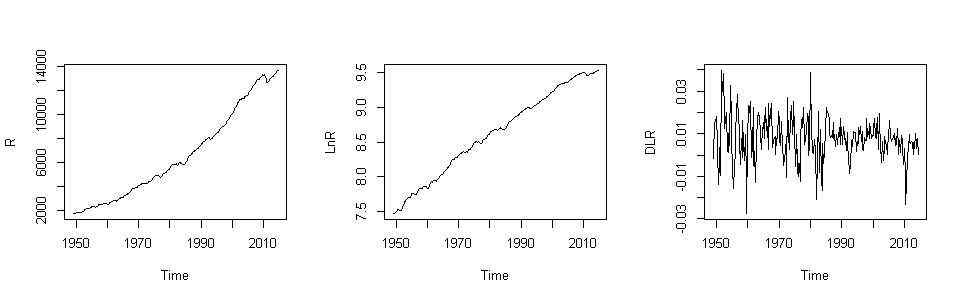

In [16]:
par(mfrow=c(1,3))

plot(R)
plot(LnR)
plot(DLR)

Ser stationært ud - måske med en lille smule positivt drift. Undersøger først om der er unit root i model med drift og trend: mindst restrektive model 

# 1. MODEL (intercept + trend)

In [20]:
trnd <- seq_along(DLR) # Definer en trend, drift er med i intercept

GDP3 <- dynlm(DLR ~ trnd + stats::lag(LnR,-1) + stats::lag(DLR,-1))
summary(GDP3)

RSS3 <- sum(residuals(GDP3)^2)
RSS3

#En anden måde at få RSS
anova(GDP3)["Residuals", "Sum Sq"]


Time series regression with "ts" data:
Start = 1949(2), End = 2014(3)

Call:
dynlm(formula = DLR ~ trnd + stats::lag(LnR, -1) + stats::lag(DLR, 
    -1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.030533 -0.004380  0.000598  0.004866  0.034333 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          1.249e-01  7.919e-02   1.577    0.116    
trnd                 1.117e-04  8.506e-05   1.313    0.190    
stats::lag(LnR, -1) -1.563e-02  1.050e-02  -1.489    0.138    
stats::lag(DLR, -1)  3.506e-01  5.786e-02   6.060 4.79e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.009106 on 258 degrees of freedom
Multiple R-squared:  0.1569,	Adjusted R-squared:  0.1471 
F-statistic:    16 on 3 and 258 DF,  p-value: 1.43e-09


[1] 0.02139095

[1] 0.02139095

$\tau_\tau$

$H_0: \gamma = 0 \qquad
H_A: \gamma \neq 0$ 

t-testen giver en værdi på **-1,489** tau-kritiskeværdier **10%**: -3.13 **5%**: -3,43

$H_0$ Hypotesen kan ikke forkastes
Kan skyldes unødvendig drift eller trend 

Tester nu joint hypotesen ved phi_3 statistikken.

$ \phi_3: a_1 = \gamma = 0 $

For at teste dette opstilles den "begrænsede" model, med ovenstående kriterier.

In [93]:
GDP2 <- dynlm(DLR ~ stats::lag(DLR,-1))
#summary(GDP2)

RSS2 <- sum(residuals(GDP2)^2)

phi3 <- ((RSS2 - RSS3)/2)/(RSS3/(262-4))
phi3

[1] 2.96569

Den kritiske værdi  for phi_3 fordelingen er på **5%**: 6,34

$H_0$ hypotesen kan således ikke forkastes - Modellen kan nu estimeres uden trend

# 2. MODEL (intercept)

In [26]:
GDP2.1 <- dynlm(DLR ~ stats::lag(LnR,-1) + stats::lag(DLR,-1))
summary(GDP2.1)

RSS4 <- sum(residuals(GDP2.1)^2)


Time series regression with "ts" data:
Start = 1949(2), End = 2014(3)

Call:
dynlm(formula = DLR ~ stats::lag(LnR, -1) + stats::lag(DLR, -1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.030204 -0.004753  0.000345  0.005290  0.035801 

Coefficients:
                      Estimate Std. Error t value Pr(>|t|)    
(Intercept)          0.0214718  0.0081146   2.646  0.00864 ** 
stats::lag(LnR, -1) -0.0019058  0.0009303  -2.049  0.04152 *  
stats::lag(DLR, -1)  0.3519467  0.0579288   6.076 4.39e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.009118 on 259 degrees of freedom
Multiple R-squared:  0.1512,	Adjusted R-squared:  0.1447 
F-statistic: 23.08 on 2 and 259 DF,  p-value: 5.988e-10


Der fortages t-test ved $\tau_\mu$
Den kritiske værdi er på **5%**: -2,89'

$H_0$ hypotesen kan således ikke forkastes. 

Tester nu for drift ved hypotesetest ved $\phi_1$ fordeling 

In [27]:
GDP1 <- dynlm(DLR ~ 0 + stats::lag(DLR,-1))
summary(GDP1)
RSS1 <- sum(residuals(GDP1)^2)


Time series regression with "ts" data:
Start = 1949(2), End = 2014(3)

Call:
dynlm(formula = DLR ~ 0 + stats::lag(DLR, -1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.022677 -0.002173  0.003462  0.008506  0.045392 

Coefficients:
                    Estimate Std. Error t value Pr(>|t|)    
stats::lag(DLR, -1)  0.61345    0.04888   12.55   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.009937 on 261 degrees of freedom
Multiple R-squared:  0.3763,	Adjusted R-squared:  0.374 
F-statistic: 157.5 on 1 and 261 DF,  p-value: < 2.2e-16


$$ \phi_1: a_0 = \gamma = 0 $$


In [28]:
phi1 <- ((RSS1 - RSS4)/2)/(RSS4/(262-3)) 
phi1

[1] 25.48504

Værdien er langt over den kritiskeværdi og det er derfor gældende 

$$\gamma \neq 0 \space og/eller \space a_0 \neq 0 $$

Laver nu t-test for nedenstående for $H_0 :a_0 = 0$

In [29]:
GDP1.1 <- dynlm(DLR ~ 1 + stats::lag(DLR,-1))
summary(GDP1.1)


Time series regression with "ts" data:
Start = 1949(2), End = 2014(3)

Call:
dynlm(formula = DLR ~ 1 + stats::lag(DLR, -1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.028447 -0.004576 -0.000031  0.005370  0.038190 

Coefficients:
                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)         0.0049140  0.0007229   6.797 7.26e-11 ***
stats::lag(DLR, -1) 0.3705749  0.0575612   6.438 5.81e-10 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.009174 on 260 degrees of freedom
Multiple R-squared:  0.1375,	Adjusted R-squared:  0.1342 
F-statistic: 41.45 on 1 and 260 DF,  p-value: 5.81e-10


Forkaster $H_0$, $a_0$er signifikant og hører derved til i modellen.


Fortager igen skridt 3 (Planen siger dog 2, men der skal testes uden trend og med drift): test-t for $\gamma=0$

In [37]:
phi2 <- ((RSS1 - RSS3)/3)/(RSS3/(262-4))
phi2

adf.test(DLR)

[1] 17.61186

Warning message in adf.test(DLR):
"p-value smaller than printed p-value"


	Augmented Dickey-Fuller Test

data:  DLR
Dickey-Fuller = -6.4226, Lag order = 6, p-value = 0.01
alternative hypothesis: stationary


# Anvendelse af car pakken

### $\gamma  = 0$ er en random walk (unit root process). Vi førsøger at afvise dette, men det giver problemer hvis modellen indeholder et intercept(drift) eller en trend, men de må kun smides ud af modellen hvis de ikke er relevante, så det skal undersøges.

### Konklusionen bliver at der er et intercept(drift) og at $\gamma$ lige er signifikant

In [94]:
reg <- dynlm(DLR ~ trnd + L(LnR,1) + L(DLR,1))
summary(reg)


Time series regression with "ts" data:
Start = 1949(2), End = 2014(3)

Call:
dynlm(formula = DLR ~ trnd + L(LnR, 1) + L(DLR, 1))

Residuals:
      Min        1Q    Median        3Q       Max 
-0.030533 -0.004380  0.000598  0.004866  0.034333 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)  1.249e-01  7.919e-02   1.577    0.116    
trnd         1.117e-04  8.506e-05   1.313    0.190    
L(LnR, 1)   -1.563e-02  1.050e-02  -1.489    0.138    
L(DLR, 1)    3.506e-01  5.786e-02   6.060 4.79e-09 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.009106 on 258 degrees of freedom
Multiple R-squared:  0.1569,	Adjusted R-squared:  0.1471 
F-statistic:    16 on 3 and 258 DF,  p-value: 1.43e-09


In [86]:
summary(reg)$coefficients["L(LnR, 1)", "t value"]

[1] -1.489117

den ligger indenfor 3.45 og -3.45 derfor kan vi ikke afvise random walk

In [96]:
linearHypothesis(reg,
                 c("L(LnR, 1) = 0", "trnd = 0"),
                 test="F")
linearHypothesis(reg,
                 c("L(LnR, 1) = 0", "(Intercept) = 0", "trnd = 0"),
                 test="F")

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
260,0.02188273,NA,NA,NA,NA
258,0.02139095,2,0.0004917747,2.96569,0.05328433


Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
261,0.02577159,NA,NA,NA,NA
258,0.02139095,3,0.004380634,17.61186,1.970711e-10


In [88]:
reg2 <- dynlm(DLR ~ L(LnR,1) + L(DLR,1))
summary(reg2)$coefficients["L(LnR, 1)", "t value"]

[1] -2.04853

Denne kan stadig ikke afvises da den ligger indenfor 2.89 og -2.89

Vi konkluderer derfor at der er en random walk, men med et drift term, altså intercept

In [89]:
linearHypothesis(reg2,
                 c("L(LnR, 1) = 0", "(Intercept) = 0"),
                 test="F")

Res.Df,RSS,Df,Sum of Sq,F,Pr(>F)
261,0.02577159,NA,NA,NA,NA
259,0.02153382,2,0.004237764,25.48504,7.877854e-11


Vi konkluderer at der er et intercept som ikke er 0

In [107]:
reg2.1 <- dynlm(DLR ~  L(DLR,1))
summary(reg2.1)$coefficients["(Intercept)", "Pr(>|t|)"]

[1] 7.255317e-11

VI kigger nu tilbage på t-værdien i regressionen med en intercept men uden trend, denne kan vi se stadig ikke er signifikant efter $\tau_t$ fordelingen

In [109]:
summary(reg2)$coefficients["L(LnR, 1)", "t value"]

[1] -2.04853

## Efter $\tau$ fordelingen er resultatet ikke signifikant og vi kan derfor ikke afvise at det er en random walk 